In [1]:
import torch
import random
import math
import numpy
import os
import pandas as pd
from PIL import Image

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np

In [2]:
#---------------------------------------------------#
#   设置种子
#---------------------------------------------------#
def seed_everything(seed=3407):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
def worker_init_fn(worker_id, seed=3407):
    worker_seed = worker_id + seed
    random.seed(worker_seed)
    np.random.seed(worker_seed)
    torch.manual_seed(worker_seed)

seed=3407
seed_everything(seed)

## 划分数据

## 加载模型

### 01-基本预训练模型

- LoRA 微调 ViT: https://github.com/huggingface/peft/blob/main/examples/image_classification/image_classification_peft_lora.ipynb

使用 LoRA 来微调 swin_v2_b 的 QV 和 fc

In [3]:
from huggingface_hub import snapshot_download

save_dir = "/root/.cache/torch/hub/checkpoints/swinv2-tiny-patch4-window16-256"

# os.makedirs(save_dir, exist_ok=True)
# snapshot_download(repo_id="microsoft/swinv2-small-patch4-window16-256", local_dir=save_dir, endpoint="https://hf-mirror.com")

In [4]:
from transformers import AutoImageProcessor
processor = AutoImageProcessor.from_pretrained(save_dir)

In [5]:
processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 256,
    "width": 256
  }
}

## 加载数据

In [6]:
class MyDataset(Dataset):
    def __init__(self, excel_name, classes=None, transform=None):
        
        self.df = pd.read_excel(io=excel_name, sheet_name="Sheet1").values
        self.transform = transform
        self.classes = classes
        self.class_to_idx = {}
        self.idx_to_class = {}
        for i in range(len(classes)):
            self.class_to_idx[classes[i]] = i
            self.idx_to_class[i] = classes[i]
        self.targets = np.array([classes.index(l) for l in self.df[:, 2]])
        
    def __len__(self):
        return self.df.shape[0]
        
    def __getitem__(self, idx):
        filename = self.df[idx,0].replace("/", "_")
        X = Image.open(f"./绘画分类数据集/{self.df[idx, 1]}/焦虑/{self.df[idx, 2]}/{filename}").convert('RGB')
        if self.transform is not None:
            X = self.transform(X)
        y = self.classes.index(self.df[idx, 2])
        return X.unsqueeze(0), y

In [7]:
def customBatchBuilder(samples):
    image, label = zip(*samples)
    
    inputs = dict()
    inputs["pixel_values"] = torch.vstack(list(image))
    inputs["labels"] = torch.tensor(label)
    return inputs

In [8]:
dataset_root = "./dataset"
batch_size = 32
num_workers = 4

mean = np.loadtxt(f"{dataset_root}/mean.txt")
std = np.loadtxt(f"{dataset_root}/std.txt")
print(mean, std)

classes = ["无（轻度）", "一般（存疑）", "重度（很明显）"]

# 定义数据转换
train_transform = transforms.Compose([
    transforms.Resize([362, 256]),  # 短边缩到 256
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform = transforms.Compose([
    transforms.Resize([362, 256]),  # 短边缩到 256
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
 
# 加载数据集
type = "树"
train_folder = MyDataset(f"{dataset_root}/{type}/train.xlsx", classes=classes, transform=train_transform)
val_folder = MyDataset(f"{dataset_root}/{type}/val.xlsx", classes=classes, transform=transform)
test_folder = MyDataset(f"{dataset_root}/{type}/test.xlsx", classes=classes, transform=transform)  # report test-dev

print("train/val/test: ", len(train_folder), len(val_folder), len(test_folder))
 
# 创建数据加载器
train_loader = DataLoader(train_folder, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_init_fn, collate_fn=customBatchBuilder)
val_loader = DataLoader(val_folder, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_init_fn, collate_fn=customBatchBuilder)
test_loader = DataLoader(test_folder, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_init_fn, collate_fn=customBatchBuilder)

[0.90696812 0.90663886 0.90883267] [0.16861193 0.16850951 0.16856439]
train/val/test:  770 111 221


In [9]:
train_labels = train_folder.targets
class_nums = len(train_folder.classes)
label2id, id2label = train_folder.class_to_idx, train_folder.idx_to_class
print(label2id, id2label)

{'无（轻度）': 0, '一般（存疑）': 1, '重度（很明显）': 2} {0: '无（轻度）', 1: '一般（存疑）', 2: '重度（很明显）'}


In [10]:
inputs = next(iter(train_loader))
for k in inputs.keys():
  print(inputs[k].shape)

torch.Size([32, 3, 362, 256])
torch.Size([32])


## 模型

In [11]:
import torch
from torch import nn

In [12]:
from sklearn.utils.class_weight import compute_class_weight

def calc_classes_weights(labels, method="balanced"):
    classes = np.unique(labels)
    nums_list=[len(np.where(labels==cl)[0]) for cl in classes]
    print(nums_list)
    if method=="balanced":
        return compute_class_weight("balanced", classes=classes, y=labels)
    elif method=="max":
        # 即用类别中最大样本数量除以当前类别样本的数量，作为权重系数
        max_nums = np.max(nums_list)
        return [max_nums/nums for nums in nums_list]
    elif method=="reciprocal":
        return [1/nums for nums in nums_list]
    else:
        pass

In [13]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [14]:
# from transformers import TrainingArguments, Trainer

# model_name = model_checkpoint.split("/")[-1]
# batch_size = 128

# args = TrainingArguments(
#     f"{model_name}-finetuned-lora-food101",
#     remove_unused_columns=False,
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=5e-3,
#     per_device_train_batch_size=batch_size,
#     gradient_accumulation_steps=4,
#     per_device_eval_batch_size=batch_size,
#     fp16=False,
#     num_train_epochs=5,
#     logging_steps=10,
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy",
#     push_to_hub=False,
#     label_names=["labels"],
# )

In [15]:
from transformers import AutoModelForImageClassification 
from peft import LoraConfig, get_peft_model

def create_lora_swin_model_from_pretrained(device, **lora_config):  # "DEFAULT" is "IMAGENET1K_V1"

    model_name = "swin_v2_t"
    pretrained_model = AutoModelForImageClassification.from_pretrained(save_dir, num_labels=class_nums,  
                        label2id=label2id, id2label=id2label, ignore_mismatched_sizes=True).to(device)
    

    merged_lora_config = LoraConfig(
        target_modules=["query", "value"],
        modules_to_save=["classifier"],
        r=lora_config["r"],
        lora_alpha=lora_config["lora_alpha"],
        lora_dropout=lora_config["lora_dropout"],
        bias=lora_config["bias"]
    )

    model = get_peft_model(pretrained_model, merged_lora_config)

    print_trainable_parameters(model)
    return model, model_name

In [32]:
from tqdm import tqdm
from IPython import display
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float32)

torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else "cpu"
start_lr = 0.0001
label_smoothing = 0.2 # no is 0
balance_weight_method = "balanced"

lora_config = dict(
    r=32,
    lora_alpha=64,
    lora_dropout=0.1,
    bias="all"
)

model, model_name = create_lora_swin_model_from_pretrained(device, **lora_config)

checkpoint = torch.load(f"./results/{type}/{model_name}/{model_name}_100.pth", map_location=device)
model.load_state_dict(checkpoint["model"])

weights = torch.FloatTensor(calc_classes_weights(train_labels, method=balance_weight_method)).to(device) # no is None
loss_fn = nn.CrossEntropyLoss(label_smoothing=label_smoothing, weight=weights)  # include softmax

optimizer = torch.optim.Adam(model.parameters(),
                            lr=start_lr,
                            betas=(0.9,0.999),
                            eps=1e-8)

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at /root/.cache/torch/hub/checkpoints/swinv2-tiny-patch4-window16-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 703107 || all params: 28148016 || trainable%: 2.50
[362, 259, 149]


## 训练

In [17]:
def train(device, model, dataloader, loss_fn, train=True, optimizer=None, useproba=True, weights=None, verbose=False):
    correct = 0
    error = 0
    total = 0
    
    fin_probas = None
    fin_ls = None
    
    for batch, ipts in enumerate(dataloader):
        X,l = ipts["pixel_values"].to(device), ipts["labels"].to(device)
        n = len(l)
        outputs = model(X).logits
        loss = loss_fn(outputs,l)
        
        if train:
            # 开始优化网络权重
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        error += loss.item()
        
        # 计算准确率
        if weights is None:
            probas = nn.functional.softmax(outputs ,dim=1)
        else:
            probas = nn.functional.softmax(weights*outputs, dim=1)
            
        p = torch.max(probas,1)[1]
        p = p.to(device)
        correct += (p == l).sum()
        total += n
        
        if verbose:
            pass
            
        if useproba:
            probas = probas.detach().cpu()
            l = l.detach().cpu()
            fin_probas = probas if fin_probas is None else np.concatenate([fin_probas, probas], axis=0)
            fin_ls = l if fin_ls is None else np.concatenate([fin_ls, l], axis=0)
    
    return error / (batch+1), correct / total, fin_probas, fin_ls

def test(device, model, dataloader, loss_fn, useproba=True, weights=None, verbose=False):
    with torch.no_grad():
        return train(device, model, dataloader, loss_fn, train=False, optimizer=None, useproba=useproba, weights=weights, verbose=verbose)

In [18]:
total_epochs = 200
save_epoch_fre = 50
save_root = f"./results/{type}/{model_name}"
os.makedirs(save_root, exist_ok=True)

In [19]:
def get_epoch_lr(cur_epoch):
    return cur_epoch

In [20]:
idxs=[]
train_errors=[]
train_accs=[]

val_errors=[]
val_accs=[]

test_errors=[]
test_accs=[]

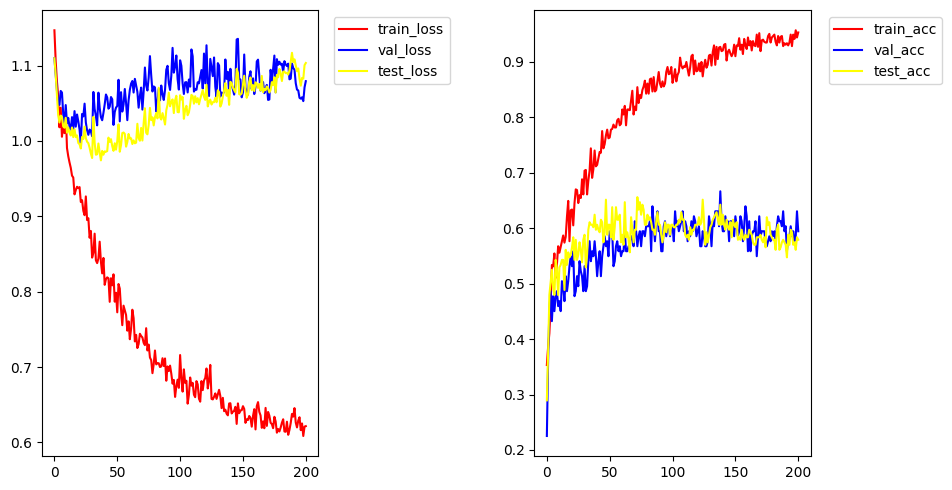

In [21]:
epoch_s = 0
epoch_e = total_epochs

rows = 1
cols = 2
best_val_acc = 0

for i in range(epoch_s, epoch_e+1):  
    if i % save_epoch_fre == 0 and i>0:
        state = { 'model': model.state_dict(), 'epoch': i, "lr": start_lr}  
        path = f"{save_root}/{model_name}_{i}.pth"
        torch.save(state, path)
        
    model.train()
    train_error,train_acc,train_probas,train_ls = train(device, model, train_loader, loss_fn, train=True, optimizer=optimizer, weights=weights)
    model.eval()
    val_error,val_acc,val_probas,val_ls = test(device, model, val_loader, loss_fn, weights=weights)
    test_error,test_acc,test_probas,test_ls = test(device, model, test_loader, loss_fn, weights=weights)

    if val_acc > best_val_acc:
        state = { 'model': model.state_dict(), 'epoch': i, "lr": start_lr}  
        path = f"{save_root}/best_val.pth"
        torch.save(state, path)
    
    idxs.append(i)  
    
    train_errors.append(train_error) 
    val_errors.append(val_error)
    test_errors.append(test_error)
    
    train_accs.append(train_acc.cpu().item())  
    val_accs.append(val_acc.cpu().item()) 
    test_accs.append(test_acc.cpu().item()) 
    
    display.clear_output(wait=True)
    
    plt.figure(figsize=(cols*5,rows*5))
    plt.subplot(rows,cols,1)
    plt.plot(idxs,train_errors,c='red',label="train_loss")
    plt.plot(idxs,val_errors,c='blue',label="val_loss")
    plt.plot(idxs,test_errors,c='yellow',label="test_loss")
    plt.legend(bbox_to_anchor=(1.5, 1), loc=1)

    plt.subplot(rows,cols,2)
    plt.plot(idxs,train_accs,c='red',label="train_acc")
    plt.plot(idxs,val_accs,c='blue',label="val_acc")
    plt.plot(idxs,test_accs,c='yellow',label="test_acc")
    plt.legend(bbox_to_anchor=(1.5, 1), loc=1)
    
    plt.tight_layout()
    plt.show()
    plt.pause(0.05)

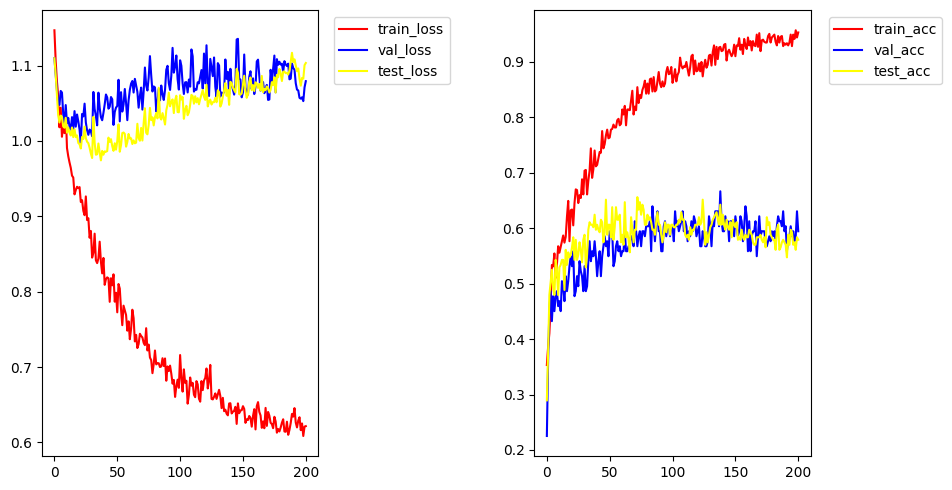

In [22]:
plt.figure(figsize=(cols*5,rows*5))
plt.subplot(rows,cols,1)
plt.plot(idxs,train_errors,c='red',label="train_loss")
plt.plot(idxs,val_errors,c='blue',label="val_loss")
plt.plot(idxs,test_errors,c='yellow',label="test_loss")
plt.legend(bbox_to_anchor=(1.5, 1), loc=1)

plt.subplot(rows,cols,2)
plt.plot(idxs,train_accs,c='red',label="train_acc")
plt.plot(idxs,val_accs,c='blue',label="val_acc")
plt.plot(idxs,test_accs,c='yellow',label="test_acc")
plt.legend(bbox_to_anchor=(1.5, 1), loc=1)

plt.tight_layout()
plt.savefig(f"{save_root}/{model_name}.jpg")

## 保存

## 效果

In [33]:
_ = model.eval()

In [34]:
def calc_top_k_acc(probas, lables, k=1):
    max_indics = np.argmax(probas, axis=1)
    return len(np.where(max_indics==lables)[0]) / len(lables)

In [35]:
test_error,test_acc,test_probas,test_ls = test(device, model, test_loader, loss_fn, weights=weights)

In [36]:
print(calc_top_k_acc(test_probas,test_ls), test_acc)

0.6063348416289592 tensor(0.6063, device='cuda:0')
